## 1 - Introduction

### 1.1 - Project Description and Objective

The ojective of this project is to develop a convolutional neural network (CNN) algorithm to accurately identify metastatic cancer in small image patches extracted from larger digital pathology scans. Metastatic cancer is a condition where cancer cells spread from the primary site of origin to other parts of the body. The detection of metastatic cancer is critical for proper diagnosis and treatment of cancer patients.

The algorithm will be trained on a large dataset of digitized histopathology images, consisting of both cancerous and non-cancerous tissue samples. The dataset will be pre-processed to extract small image patches of the tissue samples, which will be used as inputs for the CNN.

The CNN will consist of several layers, including convolutional layers for feature extraction and pooling layers for down-sampling. The architecture will also include fully connected layers for classification. The model will be trained using a supervised learning approach, where the CNN will learn to differentiate between cancerous and non-cancerous tissue samples.

The performance of the algorithm will be evaluated using several metrics, including sensitivity, specificity, and accuracy. The algorithm will also be tested on a separate dataset to assess its generalization ability. Additionally, the algorithm will be compared to existing methods for the detection of metastatic cancer in histopathology images.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from PIL import Image

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

from tensorflow.keras.utils import plot_model

import visualkeras

In [2]:
print(tf.version.VERSION)
print(tf.test.gpu_device_name())

2.10.0
/device:GPU:0


In [3]:
# Declare constants for reproduciblity
RANDOM_STATE = 27

### 1.2 Data Description

The dataset contains thousands of small images with a resolution of 96x96 pixels and 3 color channels, each labeled with a unique ID and classification. The dataset is split into a training set of 220,025 images and a testing set of approximately 57,500 images. A separate dataframe provides the ID and label information for each image, with a binary classification of 0 or 1 indicating whether the image is non-cancerous or cancerous, respectively. It is important to note that if any pixel in an image is labeled as cancerous, the entire image is classified as 1. No missing values exist in the data, which simplifies preprocessing.

In [4]:
base_path = 'C:\Downloads\MSDS\DTSA5511\CNN\data'
test_path = base_path + '/test/'
train_path = base_path + '/train/'
sample_submission = pd.read_csv(base_path + '/sample_submission.csv')
data_df = pd.read_csv(base_path + '/train_labels.csv')

#### Training Label Dataset

The initial step in the data analysis process is to inspect the training label dataset to identify potential issues such as inconsistencies or missing data. It is important to examine the dataset's structure, including the number of samples and the distribution of classes, to ensure that it is representative of the real-world problem. 

This step can help identify potential issues that may affect the performance of the machine learning model. Furthermore, understanding the data distribution can help in selecting appropriate data pre-processing and data augmentation techniques to ensure that the model is trained on high-quality data.

In [5]:
# Quick look at the dataset containing training labels
data_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


> * The "id" column, which contains the file names associated with the images, is missing the extension. The next piece of code appends it otherwise the data generator won't be able to locate them.

In [6]:
# Use a lambda function to append the string '.tif' to each value in the 'id' column
data_df['id'] = data_df['id'].apply(lambda x: x + '.tif')
data_df['label'] = data_df['label'].astype(str)

# Quick look at the dataset containing training labels after the extension was added
data_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [7]:
# Check dataset structure and missing values
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB


> * The dataset does not contain any missing values in either the 'id' or 'label' columns, which simplifies the data pre-processing step.

In [8]:
data_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

> * The distribution of classes in the dataset is slightly imbalanced, with approximately 59% of the samples belonging to class 0 and 41% belonging to class 1. This distribution is not unexpected, as the majority of tissue samples in a healthy population should ideally be non-cancerous.

#### Data Shuffling
Shuffling the input data is an important step when training a convolutional neural network (CNN) model because it helps to reduce any systematic bias that may be introduced by the ordering of the data. Without shuffling, the model may learn to recognize patterns that are specific to the order of the data, rather than patterns that are relevant to the classification task. This can result in poor generalization performance and reduced accuracy when the model is applied to new data.

Shuffling the data ensures that the model is exposed to a more diverse range of samples during training, which can improve the model's ability to generalize to new data. By randomly shuffling the data, the model is less likely to overfit to the training set and more likely to learn general features that are relevant to the classification task.

Finally, shuffling the data can also prevent bias that may be introduced by the dataset itself. For example, if the dataset is ordered by class, the model may be exposed to too many samples of one class before the other, which can lead to overfitting on that class.

In [9]:
train_df = shuffle(data_df.copy(), random_state=RANDOM_STATE)
# train_df = data_df.copy().sample(10000, random_state=RANDOM_STATE)

**Data Inspection Summary**

> * The training label dataset contains 220,025 entries and 2 columns.
> * There are no missing values in the dataset.
> * There are no duplicated entries in the dataset.
> * The id column contains the file names asssociated with the actual images.
> * The label column is represented as an integer data type, with values of 0 indicating the absence of tumor tissue and 1 indicating the presence of tumor tissue.
> * The test dataset contains 57,458 entries.

## 2 - EDA-Exploratory Data Analysis

Does it explore the dataset and include some histograms, a few other visualizations, etc.?

EDA on images is open-ended, and it can be as simple as picking a few samples of images
from each class, displaying them, and describing any findings. Some more ideas: you could
plot histograms of those sample images and draw any conclusions. You could summarize
image similarity by choosing a single metric to compare. Maybe not in our case, but if the
image sizes are different, you could mention that. Also, you can check how the range of the
pixel intensities is distributed- do you get similar max and min pixel values across images or
not?

### 2.1 - Data Distribution

As explained previously, the distribution of classes in the dataset is slightly imbalanced, with approximately 59% of the samples belonging to class 0 (non-cancerous) and 41% belonging to class 1 (cancerous). This distribution is not unexpected, as the majority of tissue samples in a healthy population should ideally be non-cancerous. The next charts help visualize the data distribution between the classes.

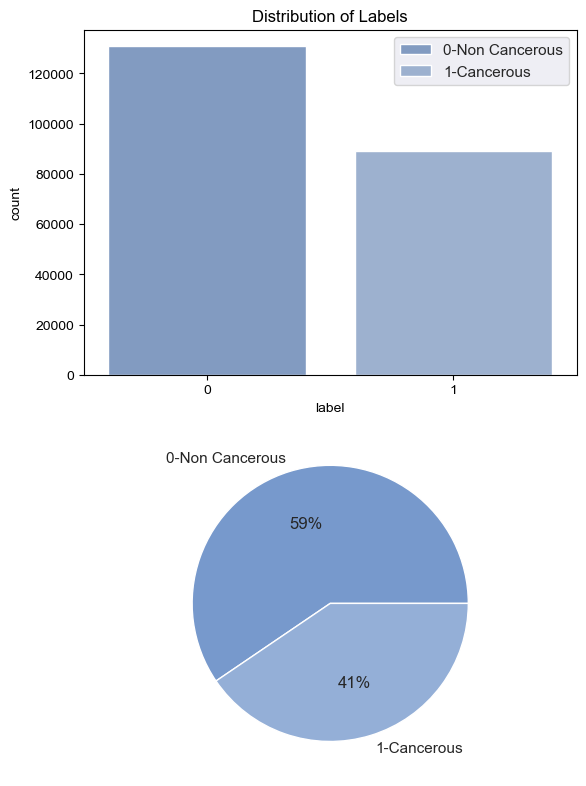

In [10]:
# Initialize figure
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Set Seaborn style
sns.set(style='darkgrid')
palette_color = sns.light_palette(color='#79C', reverse=True, n_colors=5)
labels = ['0-Non Cancerous', '1-Cancerous']

# Create plots
axs[0] = sns.countplot(x=data_df['label'], hue=data_df['label'], dodge=False,
                       palette=palette_color, ax=axs[0])
axs[0].set_title('Distribution of Labels')
axs[0].legend(labels=labels, loc='upper right')

axs[1] = plt.pie(data_df['label'].value_counts().values,
                labels=labels, colors=palette_color, autopct='%.0f%%')


# Show plots
plt.tight_layout(pad=1.0)
plt.show()
plt.close()
None

### 2.2 - Visualizing Random Images 

To gain a better understanding of the data and how it may impact our model, it is often useful to visualize some samples of the images in our dataset. In this case, we can display a few examples of both cancerous and non-cancerous images to see if there are any noticeable differences between them. These visualizations can help us understand the complexity and variability of the images, and identify any potential issues that may need to be addressed during pre-processing.

In addition to visualizing samples of the images in our dataset, it's important to note that each image has the (potentially) cancerous cells centered in each 32x32 pixel image. To emphasize this focal point, we have drawn a box around the area to better identify and isolate the cancerous cells. 

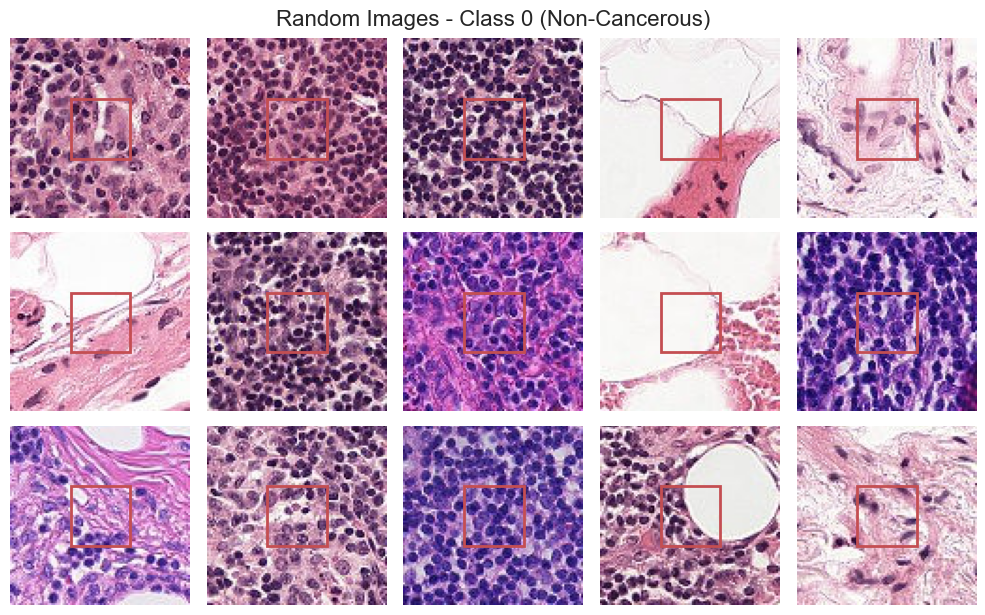

In [11]:
import matplotlib.patches as patches
# Define the number of rows and columns for the plot
num_rows = 3
num_cols = 5

# Create a subplot of the defined size
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 6))

# Define sample 
train_df_0 = data_df[data_df['label']=='0'].sample(
    num_rows * num_cols, random_state=RANDOM_STATE)

# Flatten the axes array to iterate over all subplots
axs = axs.ravel()

# Loop over the subplots and plot random images
for i, ax in enumerate(axs):
    file_name = train_df_0.iloc[i]['id']
    image = Image.open(train_path + file_name)

    # Get the image size
    img_width, img_height = image.size        

    # Create a rectangle patch
    rect = patches.Rectangle((img_width//2-16, img_height//2-16), 32, 32, 
                             linewidth=2, edgecolor='r', facecolor='none')

    # Add the rectangle patch to the image
    ax.add_patch(rect)        

    ax.imshow(image)
    ax.axis('off')

# Add a title to the plot
plt.suptitle('Random Images - Class 0 (Non-Cancerous)', y=1.02, fontsize=16)        
        
plt.tight_layout(pad=1.0)
plt.show()
None

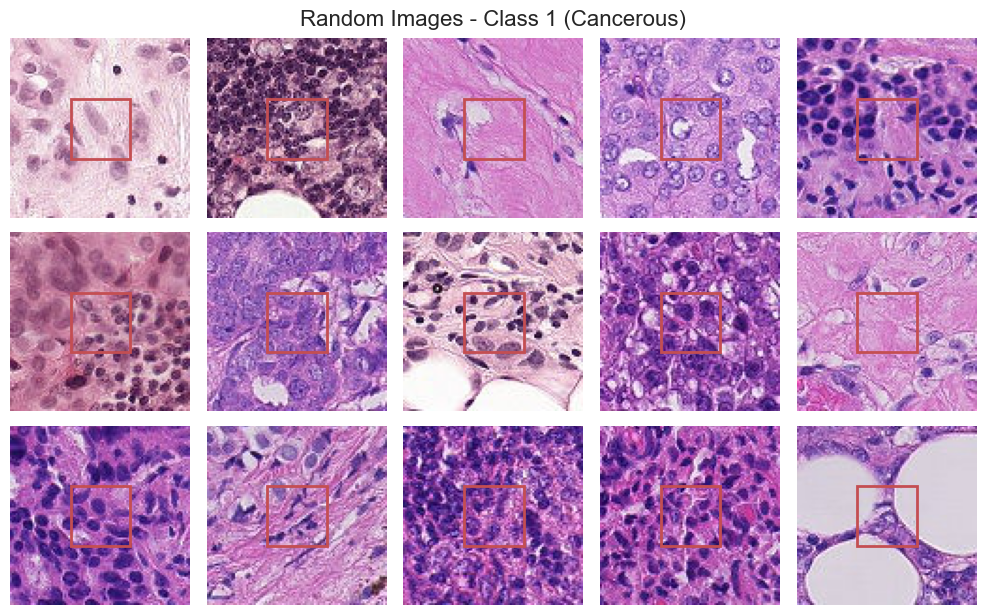

In [12]:
import matplotlib.patches as patches
# Define the number of rows and columns for the plot
num_rows = 3
num_cols = 5

# Create a subplot of the defined size
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 6))

# Define sample 
train_df_1 = data_df[data_df['label']=='1'].sample(
    num_rows * num_cols, random_state=RANDOM_STATE)

# Flatten the axes array to iterate over all subplots
axs = axs.ravel()

# Loop over the subplots and plot random images
for i, ax in enumerate(axs):
    file_name = train_df_1.iloc[i]['id']
    image = Image.open(train_path + file_name)

    # Get the image size
    img_width, img_height = image.size        

    # Create a rectangle patch
    rect = patches.Rectangle((img_width//2-16, img_height//2-16), 32, 32, 
                             linewidth=2, edgecolor='r', facecolor='none')

    # Add the rectangle patch to the image
    ax.add_patch(rect)        

    ax.imshow(image)
    ax.axis('off')

# Add a title to the plot
plt.suptitle('Random Images - Class 1 (Cancerous)', y=1.02, fontsize=16)        
        
plt.tight_layout(pad=1.0)
plt.show()
None

## 3 - Data Preprocessing

Data preprocessing is essential in CNN because it can significantly impact the performance of the model. This is because CNNs are sensitive to the scale and distribution of the input data. Preprocessing techniques such as normalization, data augmentation, and feature scaling can help to standardize the data and reduce noise, which can improve the accuracy and speed of the model. Additionally, preprocessing can help to address issues such as class imbalance, missing data, and outliers, which can negatively impact the model's ability to learn from the data. Overall, effective data preprocessing is critical for improving the generalization and robustness of CNN models.

Below are the preprocessing parameters that have been used in this project. These parameters are important in CNN because they help to augment the training data and increase its variety, which in turn can improve the generalization performance of the model.

* **rescale:** parameter rescales the pixel values of the images to a range between 0 and 1. This is a common pre-processing step to standardize the input data. It standardizes the input data to a common range, which helps in faster convergence and more stable training

* **shear_range:** applies random shearing transformations to the images. Shearing changes the shape of the object in the image by shifting the pixels along a certain direction. It can help the model learn to be invariant to shearing, which is a common distortion in real-world images

* **zoom_range applies:** random zoom transformations to the images. This changes the scale of the object in the image by zooming in or out. It can help the model learn to be invariant to changes in scale and handle objects at different distances.

* **horizontal_flip parameter:** flips the images horizontally, which can increase the size of the training data and provide more variation. It can help the model learn to be invariant to horizontal flips, which can occur in real-world images due to reflections or orientation changes.

* **rotation_range:** applies random rotations to the images by a specified degree. This can help the model learn to be invariant to rotation. It can help the model learn to be invariant to rotation, which can be useful when images may be taken at different angles or orientations.

* **width_shift_range:** shifts the images horizontally by a fraction of the image width. This can help the model learn to be invariant to translation. It can help the model learn to be invariant to translation, which can occur due to changes in camera position or object position.

* **height_shift_range:** shifts the images vertically by a fraction of the image height. It can help the model learn to be invariant to translation in the vertical direction.

* **fill_mode:** specifies the strategy to fill the missing pixels after transformation. Here, the nearest pixel value is used to fill in the missing pixels. It determines how missing pixels are filled in after transformation. Using the nearest pixel value helps to preserve the original structure of the image and avoid introducing any new artifacts.

* **shuffle:** the training label dataframe has been already shuffled therefore I need to set this to  false to enable consistent label assignment to images otherwise the confusion matrix and ROC-AUC plots will be incorrect.

In [13]:
%%time

# Define batch size
batch_size = 128

# Create an instance of the ImageDataGenerator class with rescaling and validation split
datagen = ImageDataGenerator(
    rescale=1./255.,      # Scale pixel values to be between 0 and 1
    validation_split=0.20 # Split the data into a training and validation set with a 80/20 ratio
)

# Define generators for training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,     # training dataframe containing file names and labels
    directory=train_path,   # path to image directory
    x_col='id',             # column name in dataframe containing file names
    y_col='label',          # column name in dataframe containing labels
    target_size=(96, 96),   # Shape of all images 
    batch_size=batch_size,  # Set batch size
    shear_range=0.2,        # Apply random shear transformations
    zoom_range=0.2,         # Apply random zoom transformations
    horizontal_flip=True,   # Flip images horizontally
    rotation_range=40,      # Apply random rotations
    width_shift_range=0.2,  # Shift images horizontally
    height_shift_range=0.2, # Shift images vertically
    fill_mode='nearest',    # Fill missing pixels with nearest pixel value    
    class_mode='binary',    # Use binary classification (0 or 1)
    subset='training',      # Use subset of data for training   
    shuffle=False           # set it to false for consistent label assignment to images
)

# Define generators for validation data
val_generator = datagen.flow_from_dataframe(
    dataframe=train_df,     # training dataframe containing file names and labels
    directory=train_path,   # path to image directory
    x_col='id',             # column name in dataframe containing file names
    y_col='label',          # column name in dataframe containing labels
    target_size=(96, 96),   # Shape of all images 
    batch_size=batch_size,  # Set batch size
    shear_range=0.2,        # Apply random shear transformations
    zoom_range=0.2,         # Apply random zoom transformations
    horizontal_flip=True,   # Flip images horizontally
    rotation_range=40,      # Apply random rotations
    width_shift_range=0.2,  # Shift images horizontally
    height_shift_range=0.2, # Shift images vertically    
    fill_mode='nearest',    # Fill missing pixels with nearest pixel value    
    class_mode='binary',    # Use binary classification (0 or 1)
    subset='validation',    # Use subset of data for validation
    shuffle=False           # set it to false for consistent label assignment to images
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Wall time: 15.8 s


## 4 - Model Architecture

My approach to building the model architecture involves leveraging pre-trained models, building a base model with basic building blocks of a CNN architecture, and optimizing the model using various techniques learned in class. By following these steps and experimenting with different techniques, I hope to build a robust and accurate model for my image classification task:

**Step 1: Building the Baseline Model with Transfer Learning**

* In the first step, I will use transfer learning to build a baseline model for the image classification task. Transfer learning is a powerful technique that allows us to leverage pre-trained models to improve the performance of our models. For this task, I will use a pre-trained ResNet model as the starting point for my model.

* To build the baseline model, I will remove the last few layers of the ResNet model and add a new classification layer on top. This new layer will be trained from scratch, while the rest of the model will remain frozen. I will then train the model on my dataset and evaluate its performance on a validation set. This will give me a baseline performance metric that I can use to compare my subsequent models.

**Step 2: Building the Base Model with Basic Building Blocks of a CNN Architecture**

* In the second step, I will build a base model using the basic building blocks of a CNN architecture, such as convolutional layers, pooling layers, and fully connected layers. The objective of this step is to create a model that can be used as a starting point for hyperparameter tuning.

* I will start with a simple architecture and gradually increase its complexity as I fine-tune the hyperparameters. I will also experiment with different activation functions, weight initializations, and optimization algorithms to see how they affect the model's performance.

* Once I have built the base model, I will train it on my dataset and evaluate its performance on a validation set. This will give me an idea of the model's performance and help me identify areas for improvement.

**Step 3: Optimizing the Base Model with Various Techniques Learned in Class**

* In the third and final step, I will optimize the base model using various techniques learned in class. These techniques include hyperparameter tuning, data augmentation, and regularization.

* Hyperparameter tuning involves adjusting the model's hyperparameters to improve its performance. I will experiment with different learning rates, batch sizes, and number of epochs to find the optimal values for my model.

* Data augmentation involves generating new training samples by applying random transformations to the existing images, such as rotations, flips, and zooms. This can help prevent overfitting and improve the model's generalization ability.

* Regularization involves adding constraints to the model to prevent overfitting. I will experiment with different regularization techniques, such as L1 and L2 regularization and dropout, to see how they affect the model's performance.

### Evaluation Metrics

When it comes to evaluating the performance of a machine learning model, it is important to consider a range of metrics that provide a comprehensive view of the model's strengths and weaknesses. In the context of this project, which has a medical focus, we will consider four major metrics: AUC, MSE, accuracy, and recall.

* **AUC:** is a common metric used to evaluate the performance of binary classification models, such as those used to predict whether a patient has a certain condition or not. A high AUC score indicates that the model is able to correctly distinguish between positive and negative cases with a high degree of accuracy. Note that AUC is the metric selected by the Kaggle competition as the primary evaluation metric for this project.

* **MSE:** is a metric used to evaluate the accuracy of regression models, which are used to predict numerical values, such as a patient's blood pressure or cholesterol level. A low MSE score indicates that the model is able to predict these values with a high degree of accuracy.

* **Accuracy:** is a metric used to evaluate the performance of classification models. It measures the proportion of correct predictions made by the model out of all the predictions made. While accuracy is an important metric, it may not always be the most suitable metric for evaluating models in medical contexts.

* **Recall:** In medical contexts, recall is a particularly important metric to consider. Recall measures the proportion of true positive cases that were correctly identified by the model. In other words, it indicates the model's ability to identify all cases of a certain condition or disease. In medical contexts, it is often more important to correctly identify all cases of a certain condition or disease, even if it means some false positives, than to miss any true positives.

#### Helper Functions

This section contains a collection of functions that will be used for various common tasks, such as plotting and reporting. These functions are designed to streamline the coding process.

In [14]:
"""
Plot AUC, MSE, Accuracy and Recall charts for a given model
Inputs:
    chart_df: Pandas dataframe with metrics computed during training
    plot_val: boolean to indicate whether to plot validation results
Outputs:
    None
"""
def plot_model(chart_df, plot_val=True):
    
    # Initialize figure
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))

    # Set Seaborn style
    sns.set(style='darkgrid')

    # Create lineplots
    axs[0, 0] = sns.lineplot(data=chart_df, x='epoch', y='auc', ax=axs[0, 0])
    axs[0, 1] = sns.lineplot(data=chart_df, x='epoch', y='mse', ax=axs[0, 1])
    axs[1, 0] = sns.lineplot(data=chart_df, x='epoch', y='accuracy', ax=axs[1, 0])
    axs[1, 1] = sns.lineplot(data=chart_df, x='epoch', y='recall', ax=axs[1, 1])
    
    # Plot validation results if requested
    if plot_val: 
        axs[0, 0] = sns.lineplot(data=chart_df, x='epoch', y='val_auc', ax=axs[0, 0])
        axs[0, 1] = sns.lineplot(data=chart_df, x='epoch', y='val_mse', ax=axs[0, 1])
        axs[1, 0] = sns.lineplot(data=chart_df, x='epoch', y='val_accuracy', ax=axs[1, 0])
        axs[1, 1] = sns.lineplot(data=chart_df, x='epoch', y='val_recall', ax=axs[1, 1])        
        fig.legend(labels=['train', 'validation'], loc='lower left')
    else:
        fig.legend(labels=['train'], loc='lower left')

    # Axes labels
    axs[0, 0].set(xlabel='Epoch', ylabel='AUC')        
    axs[0, 1].set(xlabel='Epoch', ylabel='MSE')
    axs[1, 0].set(xlabel='Epoch', ylabel='Accuracy')   
    axs[1, 1].set(xlabel='Epoch', ylabel='Recall')    
    
    # Show plot
    plt.tight_layout(pad=1.2)
    plt.show()
    plt.close()
    None

### 4.1 - Transfer Learning using Pretrained ResNet Model

Transfer learning is a technique that allows us to leverage a pre-trained model's knowledge and apply it to a new task. In the context of computer vision, this often involves using pre-trained models on large datasets, such as ImageNet, to improve the performance of a model on a smaller dataset.

ResNet, short for Residual Network, is a deep learning model that has been pre-trained on ImageNet, a large dataset of labeled images. The ResNet model consists of a series of convolutional layers, followed by several residual blocks. These blocks allow the model to learn from the residual or error signal, rather than just the input, which improves the model's accuracy.

To use ResNet for transfer learning, we typically start by removing the last few layers of the pre-trained model. These layers are typically designed for the specific classification task on which the model was trained, and may not be suitable for our new task.

Once I have removed these layers, I will add a new set of layers that are tailored to the specific task. For the specific image classification model, I will add a fully connected layer on top of the ResNet model that outputs the predicted class labels.

I then freeze the pre-trained layers in the ResNet model, so they do not change during training. This allows me to use the pre-trained weights as a starting point for our new model, rather than starting from scratch.

Next, I train the new layers that we added to the model using our own dataset. During training, the weights of the new layers are updated to minimize the error between the predicted outputs and the true labels of the dataset.

In [15]:
# Load the ResNet50 model
resnet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze the layers in the ResNet50 model
for layer in resnet_model.layers:
    layer.trainable = False

# Add your classification layer
x = Flatten()(resnet_model.output)
output_layer = Dense(1, activation='sigmoid')(x)    
model= Model(inputs=resnet_model.input, outputs=output_layer)

# Set up the optimizer
optimizer = optimizer = SGD(learning_rate=0.001, momentum=0.9)

# Compile the model with binary cross-entropy loss and SGD optimizer
model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['AUC', 'mse', 'accuracy', 'Recall'])

# Print the model summary
# model.summary()

In [16]:
%%time
epochs = 10

# Fit the pre-trained model
model_history = model.fit(x=train_generator, 
                          validation_data=val_generator, 
                          epochs=epochs)

Epoch 1/10
1376/1376 [==============================] - 171s 120ms/step - loss: 0.4129 - auc: 0.8944 - mse: 0.1272 - accuracy: 0.8229 - recall: 0.7618 - val_loss: 0.3858 - val_auc: 0.9099 - val_mse: 0.1164 - val_accuracy: 0.8402 - val_recall: 0.7409
Epoch 2/10
1376/1376 [==============================] - 159s 116ms/step - loss: 0.3775 - auc: 0.9109 - mse: 0.1159 - accuracy: 0.8397 - recall: 0.7841 - val_loss: 0.3837 - val_auc: 0.9090 - val_mse: 0.1170 - val_accuracy: 0.8394 - val_recall: 0.7444
Epoch 3/10
1376/1376 [==============================] - 159s 115ms/step - loss: 0.3674 - auc: 0.9155 - mse: 0.1126 - accuracy: 0.8439 - recall: 0.7888 - val_loss: 0.4121 - val_auc: 0.9100 - val_mse: 0.1262 - val_accuracy: 0.8252 - val_recall: 0.8576
Epoch 4/10
1376/1376 [==============================] - 159s 116ms/step - loss: 0.3631 - auc: 0.9176 - mse: 0.1115 - accuracy: 0.8455 - recall: 0.7930 - val_loss: 0.3743 - val_auc: 0.9131 - val_mse: 0.1131 - val_accuracy: 0.8437 - val_recall: 0.7949


In [17]:
# Create Pandas dataframe with metrics from training
chart_df = pd.DataFrame(model_history.history)
chart_df.insert(loc=0, column='epoch', value=np.arange(1, len(chart_df) + 1))
chart_df.insert(loc=0, column='model', value='ResNet50V2')

# Create a summary dataframe to be used for final comparison and
#   add the epoch with best AUC result
summary_df = chart_df.sort_values(by=['auc'], ascending=False)[0:1].copy()
summary_df.reset_index(inplace=True, drop=True)
summary_df

,model,epoch,loss,auc,mse,accuracy,recall,val_loss,val_auc,val_mse,val_accuracy,val_recall
0,ResNet50V2,10,0.345185,0.925167,0.105921,0.853426,0.80284,0.399942,0.910779,0.121796,0.831974,0.841941


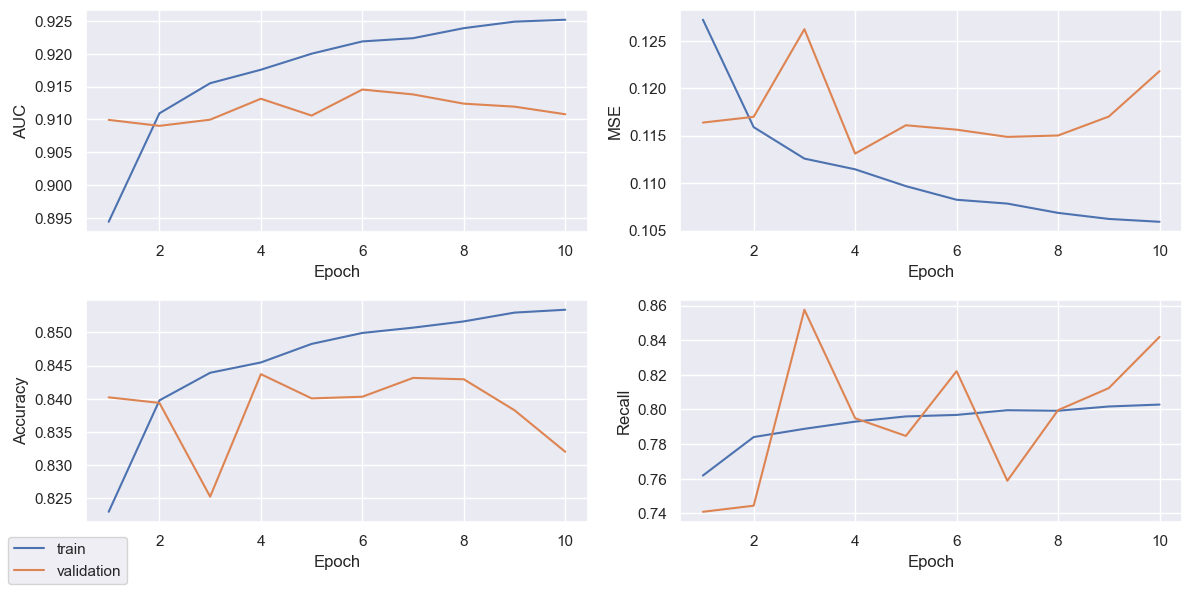

In [18]:
plot_model(chart_df)

#### Analysis of the Results

Based on the provided textual analysis of the results for the ResNet50V2 model, we can draw the following conclusions:

> * The model used in this experiment is ResNet50V2 and was trained for 10 epochs. During training, the model scored well in the loss function, AUC, MSE and accuracy. These results indicate that the model performed relatively well in training and was able to accurately predict the target variable. The high AUC score indicates that the model was able to distinguish between the positive and negative classes effectively.
> * However, the validation loss higher than the training loss. This difference may indicate that the model is overfitting, meaning that it is too complex and is memorizing the training data. The AUC score on the validation was lower than the training AUC score, indicating that the model may not be performing as well on new data. The validation MSE, accuracy and recall scores are slightly lower than the training results, which further indicates that the model may be overfitting to some extent.
> * We can also observe that the validation data experienced significant fluctuations in most of the metrics evaluated over the epochs. There can be several reasons for that, for example the complexity of the architecture or the size and quality of the validation dataset. In any case, this behavior again seems to corroborate the fact that the model is experiencing overfitting. 
> * In summary, while the ResNet50V2 model the model achieved decent results, but there are signs of be some **overfitting**, and further steps may be necessary to improve the model's performance on unseen data. It may be beneficial to implement techniques such as regularization, dropout, or adjusting the model's complexity to prevent overfitting.

### 4.2 - Base Model

For the base model, I have chosen a commonly used CNN architecture that provides a simple yet effective starting point by using basic building blocks of a typical CNN architecture. This model includes several layers that are commonly found in image classification tasks, including:

* **Input layer**: The input layer will accept 96x96x3 images as input.
* **Convolutional layers:** The first layer of the network is a convolutional layer with 16 filters of size 3x3, followed by another convolutional layer with the same configuration. These convolutional layers will extract features from the input images such as edges and shapes. 
* **Max pooling layer:** The output of the second convolutional layer is then fed into a max pooling layer with a pool size of 2x2, which reduces the spatial dimensions of the feature maps and helps to prevent overfitting.
* **Convolutional layer:** Next, there are two more convolutional layers with 32 filters of size 3x3. These layers will continue to extract features from the reduced spatial dimensions of the input.
* **Average pooling layer:** After the second set of convolutional layers, an average pooling layer with a pool size of 2x2 is added. This layer reduces the spatial dimensions of the feature maps again.
* **Flatten and Output layer:** The output of the average pooling layer is then flattened into a 1D array, which is fed into a dense layer with a single neuron and sigmoid activation. This dense layer will map the extracted features to a single binary output indicating the class of the input image.

In [19]:
# Define the model architecture
model = Sequential()

# Add convolutional layers with 16 filters of size 3x3
model.add(Conv2D(filters=16, kernel_size=(3, 3)))
model.add(Conv2D(filters=16, kernel_size=(3, 3)))

# Add a max pooling layer with a pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add convolutional layers with 32 filters of size 3x3
model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(Conv2D(filters=32, kernel_size=(3, 3)))

# Add an average pooling layer with a pool size of 2x2
model.add(AveragePooling2D(pool_size=(2, 2)))

# Add a flatten layer to convert the output to a 1D array
model.add(Flatten())

# Add a dense layer with a single neuron and sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Set the input shape to image size and build the model
model.build(input_shape=(batch_size, 96, 96, 3))

# Compile the model with binary cross-entropy loss and multiple metrics
model.compile(loss='binary_crossentropy', 
              metrics=['AUC', 'mse', 'accuracy', 'Recall'])

# Print the model summary
# model.summary()

In [20]:
%%time
epochs = 10

# Fit the model
model_history = model.fit(x=train_generator, 
                          validation_data=val_generator, 
                          epochs=epochs)

Epoch 1/10
1376/1376 [==============================] - 144s 103ms/step - loss: 0.5936 - auc: 0.7425 - mse: 0.2005 - accuracy: 0.6954 - recall: 0.5125 - val_loss: 0.5266 - val_auc: 0.8319 - val_mse: 0.1755 - val_accuracy: 0.7381 - val_recall: 0.4513
Epoch 2/10
1376/1376 [==============================] - 142s 104ms/step - loss: 0.5054 - auc: 0.8248 - mse: 0.1653 - accuracy: 0.7615 - recall: 0.6396 - val_loss: 0.4790 - val_auc: 0.8462 - val_mse: 0.1554 - val_accuracy: 0.7777 - val_recall: 0.6487
Epoch 3/10
1376/1376 [==============================] - 142s 104ms/step - loss: 0.4865 - auc: 0.8390 - mse: 0.1580 - accuracy: 0.7745 - recall: 0.6657 - val_loss: 0.4725 - val_auc: 0.8547 - val_mse: 0.1523 - val_accuracy: 0.7842 - val_recall: 0.7531
Epoch 4/10
1376/1376 [==============================] - 142s 103ms/step - loss: 0.4744 - auc: 0.8475 - mse: 0.1535 - accuracy: 0.7803 - recall: 0.6802 - val_loss: 0.4782 - val_auc: 0.8476 - val_mse: 0.1554 - val_accuracy: 0.7784 - val_recall: 0.7327


In [21]:
# Create Pandas dataframe with metrics from training
chart_df = pd.DataFrame(model_history.history)
chart_df.insert(loc=0, column='epoch', value=np.arange(1, len(chart_df) + 1))
chart_df.insert(loc=0, column='model', value='Base Model')

# Append epoch with best AUC result to summary dataframe 
summary_df = summary_df.append(chart_df.sort_values(by=['auc'], ascending=False)[0:1].copy())
summary_df.reset_index(inplace=True, drop=True)
summary_df

,model,epoch,loss,auc,mse,accuracy,recall,val_loss,val_auc,val_mse,val_accuracy,val_recall
0,ResNet50V2,10,0.345185,0.925167,0.105921,0.853426,0.802840,0.399942,0.910779,0.121796,0.831974,0.841941
1,Base Model,10,0.432682,0.875726,0.138173,0.804721,0.727804,0.461432,0.865015,0.149137,0.785024,0.789292


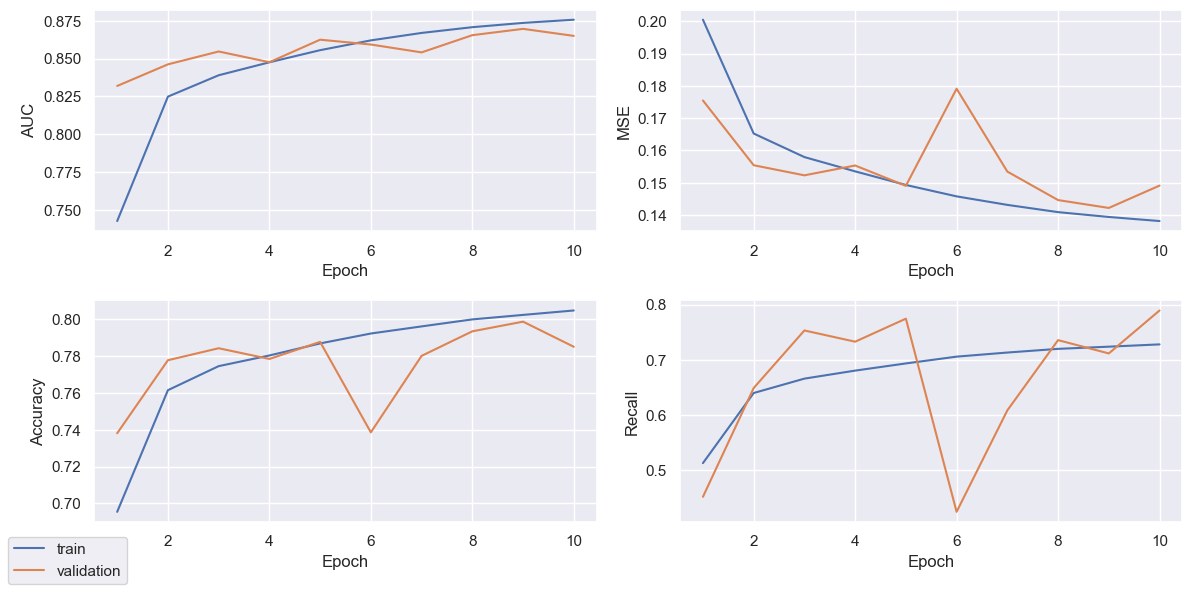

In [22]:
plot_model(chart_df)

#### Analysis of the Results

> * From the results for the performance of a "Base Model" with 10 epochs, we can observe that the model is suffering from **underfitting**, as both the training and validation data are not performing very well. The training data is showing a relatively high loss and low accuracy, while the validation data is showing similar results. This indicates that the model is not capturing the underlying patterns in the data, and is not able to generalize well to new, unseen examples.
> * The AUC scores for both training and validation data are relatively low, indicating that the model is not able to distinguish well between positive and negative examples. The recall scores are also relatively low, especially for the validation data, which further confirms that the model is not able to capture the relevant patterns in the data.
> * It's worth noting that the validation data is showing slightly worse results than the training data, which may indicate some overfitting. However, since the overall performance of the model is not very good, this overfitting is not likely to be the main issue. It's more likely that the model architecture or hyperparameters need to be adjusted in order to improve its performance. Further experimentation with different architectures or hyperparameters may be necessary to achieve better results.

### 4.2 - Hyperparameter Tuning

In a CNN context, hyperparameter tuning plays a crucial role in achieving high accuracy and robustness of the model. To achieve the best possible optimization, I will employ a systematic approach using a combination of common techniques and other proven methods that involve testing different values for each hyperparameter.

Given the substantial training time required for a CNN model, I will avoid exhaustive methods like grid search or random search, which can be time-consuming and resource-intensive. Instead, I will focus on more feasible yet effective methods that are better suited for CNN models.

By systematically tuning the hyperparameters, I can ensure that the model achieves the best performance while avoiding overfitting or underfitting the data. Moreover, this approach can help me gain a deeper understanding of the model's behavior and how each hyperparameter affects its performance.

### 4.2.1 - Optimization #1

Given the fact that the model is experiencing overfitting I will start with the optimization with first two optimizations below:

* **Dropout layer**: add a dropout layer after the first set of convolutional layers. Dropout layers can help prevent overfitting by randomly dropping out some neurons during training. I will add a dropout rate of 0.25 after the second convolutional layer.
* **Optimizer**: I will add SGD as an optimizer. SGD (Stochastic Gradient Descent) is a commonly used optimizer in neural network training and a good starting point. It updates the model parameters based on the gradient of the loss function with respect to the parameters, in order to minimize the loss function.

The remaining layers will remain as the original base model but will be further improved later.

In [23]:
# Define the model architecture
model = Sequential()

# Add convolutional layers with 16 filters of size 3x3
model.add(Conv2D(filters=16, kernel_size=(3, 3)))
model.add(Conv2D(filters=16, kernel_size=(3, 3)))

# Add a dropout layer with a dropout rate of 0.25
model.add(Dropout(0.25))

# Add a max pooling layer with a pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add convolutional layers with 32 filters of size 3x3
model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(Conv2D(filters=32, kernel_size=(3, 3)))

# Add an average pooling layer with a pool size of 2x2
model.add(AveragePooling2D(pool_size=(2, 2)))

# Add a flatten layer to convert the output to a 1D array
model.add(Flatten())

# Add a dense layer with a single neuron and sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Set the input shape to image size and build the model
model.build(input_shape=(batch_size, 96, 96, 3))

# Set up the optimizer
optimizer = optimizer = SGD(learning_rate=0.001, momentum=0.9)

# Compile the model with binary cross-entropy loss and SGD optimizer
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['AUC', 'mse', 'accuracy', 'Recall'])

In [24]:
%%time
epochs = 10

# Fit the model
model_history = model.fit(x=train_generator, 
                          validation_data=val_generator, 
                          epochs=epochs)

Epoch 1/10
1376/1376 [==============================] - 144s 104ms/step - loss: 0.5282 - auc: 0.8054 - mse: 0.1747 - accuracy: 0.7458 - recall: 0.6080 - val_loss: 2.7178 - val_auc: 0.5880 - val_mse: 0.4964 - val_accuracy: 0.4211 - val_recall: 0.9996
Epoch 2/10
1376/1376 [==============================] - 142s 103ms/step - loss: 0.4375 - auc: 0.8709 - mse: 0.1389 - accuracy: 0.8061 - recall: 0.7222 - val_loss: 3.6138 - val_auc: 0.6278 - val_mse: 0.5611 - val_accuracy: 0.4071 - val_recall: 1.0000
Epoch 3/10
1376/1376 [==============================] - 142s 103ms/step - loss: 0.4251 - auc: 0.8782 - mse: 0.1345 - accuracy: 0.8125 - recall: 0.7294 - val_loss: 3.3780 - val_auc: 0.5413 - val_mse: 0.5386 - val_accuracy: 0.4080 - val_recall: 1.0000
Epoch 4/10
1376/1376 [==============================] - 143s 104ms/step - loss: 0.4152 - auc: 0.8841 - mse: 0.1311 - accuracy: 0.8172 - recall: 0.7374 - val_loss: 3.6037 - val_auc: 0.5329 - val_mse: 0.5242 - val_accuracy: 0.4135 - val_recall: 0.9993


In [25]:
# Create Pandas dataframe with metrics from training
chart_df = pd.DataFrame(model_history.history)
chart_df.insert(loc=0, column='epoch', value=np.arange(1, len(chart_df) + 1))
chart_df.insert(loc=0, column='model', value='Optimized Model 1')

# Append epoch with best AUC result to summary dataframe 
summary_df = summary_df.append(chart_df.sort_values(by=['auc'], ascending=False)[0:1].copy())
summary_df.reset_index(inplace=True, drop=True)
summary_df

,model,epoch,loss,auc,mse,accuracy,recall,val_loss,val_auc,val_mse,val_accuracy,val_recall
0,ResNet50V2,10,0.345185,0.925167,0.105921,0.853426,0.802840,0.399942,0.910779,0.121796,0.831974,0.841941
1,Base Model,10,0.432682,0.875726,0.138173,0.804721,0.727804,0.461432,0.865015,0.149137,0.785024,0.789292
2,Optimized Model 1,10,0.390135,0.899177,0.122107,0.830434,0.754431,3.777455,0.441488,0.511305,0.426247,0.961532


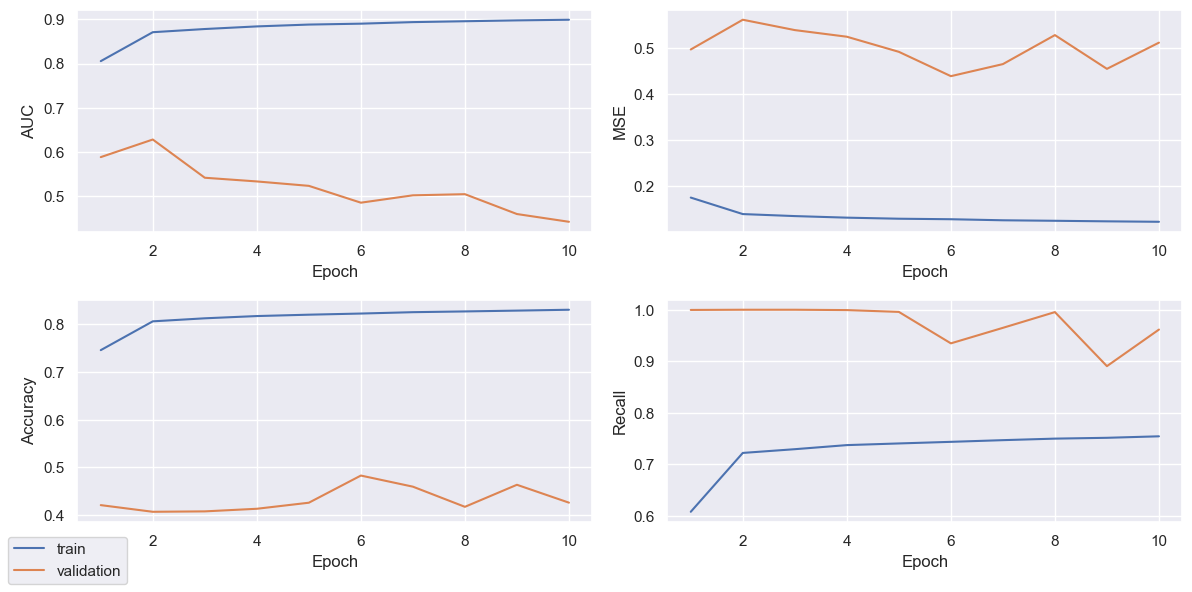

In [26]:
plot_model(chart_df)

#### Analysis of the Results

> * After the first round of optimization, we can observe that the training data results for this base model after 10 epochs are reasonably good, with decents scores for loss, AUC, MSE, accuracy and. These results indicate that the model is learning something from the training data, although it could possibly be improved. The AUC score suggests that the model has some ability to discriminate between positive and negative examples, while the accuracy score indicates that the model is making accurate predictions most of the time.
> * However, the validation data results are **very poor**, with a very high loss and low AUC, MSE and accuracy scores. These results suggest that the model is **severely overfitting** to the training data and is not generalizing well to new data. The high loss and low accuracy suggest that the model is making mostly incorrect predictions on the validation data. The high recall score on the validation data is somewhat unexpected and could indicate that the model is biased towards predicting positive examples.
> * In summary, these results suggest that the model is extremely overfitting to the training data and not generalizing well to new data at all. The training data results are decent, but the validation data results are **very poor**, indicating that the model needs to be improved to avoid overfitting. Possible solutions include increasing the size of the validation set, increasing the regularization of the model, or reducing the complexity of the model.

### 4.2.2 - Optimization #2

The first round of hyperparameter optimization clearly did not produce the desired results, so I made significant changes to the model in the second round. I increased the complexity of the model by adding more layers, increased the dropout rate to prevent overfitting, changed the activation functions of the convolutional layers to improve performance, changed the learning rate to fine-tune the model, and switched to the Adam optimizer to improve the training process. 

The resulting architecture is more sophisticated and should be better suited to the data, with improved accuracy and performance. The new model architecture includes multiple convolutional layers with ReLU and max pooling, followed by a dense layer with dropout and sigmoid activation to generate the final output. Overall, these changes should improved the performance of the model and helped achieve better results on the classification task.

The architecture consists of the following layers now:

* **Input layer:** The input layer will accept 96x96x3 images as input.
* **Convolutional layer:** The first layer of the CNN will be a convolutional layer with 32 filters of size 3x3, a stride of 1, and ReLU activation. This layer will learn to detect low-level features like edges and textures.
* **Max pooling layer:** A max pooling layer with a pool size of 2x2 and a stride of 2 will be added to reduce the spatial dimensions of the input and make the model more computationally efficient.
* **Convolutional layer:** Another convolutional layer with 64 filters of size 3x3, a stride of 1, and ReLU activation will be added. This layer will learn higher-level features that are combinations of the low-level features learned by the previous layer.
* **Max pooling layer:** Another max pooling layer with a pool size of 2x2 and a stride of 2 will be added.
* **Convolutional layer:** Another convolutional layer with 128 filters of size 3x3, a stride of 1, and ReLU activation will be added. This layer will learn even higher-level features.
* **Max pooling layer:** Another max pooling layer with a pool size of 2x2 and a stride of 2 will be added.
* **Flatten layer:** A flatten layer will be added to convert the 3D tensor output from the previous layer into a 1D vector that can be used as input to the fully connected layers.
* **Fully connected layer:** A fully connected layer with 256 neurons and ReLU activation will be added. This layer will learn to combine the features learned by the convolutional layers to make a prediction about the presence of tumor tissue in the center 32x32 region of the image.
* **Dropout layer:** A dropout layer with a rate of 0.5 will be added to prevent overfitting.
* **Output layer:** Finally, an output layer with a single neuron and sigmoid activation will be added to make a binary prediction (tumor present or not present) based on the output of the previous layer.

In [27]:
# Create a sequential model
model = Sequential()

# Add convolutional layer with 32 filters, kernel size of 3x3, and ReLU activation
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))

# Add max pooling layer with pool size of 2x2 and stride of 2
model.add(MaxPooling2D((2, 2)))

# Add convolutional layer with 64 filters, kernel size of 3x3, and ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add max pooling layer with pool size of 2x2 and stride of 2
model.add(MaxPooling2D((2, 2)))

# Add convolutional layer with 128 filters, kernel size of 3x3, and ReLU activation
model.add(Conv2D(128, (3, 3), activation='relu'))

# Add max pooling layer with pool size of 2x2 and stride of 2
model.add(MaxPooling2D((2, 2)))

# Flatten the output of the previous layer to create a 1D vector
model.add(Flatten())

# Add fully connected layer with 256 neurons and ReLU activation
model.add(Dense(256, activation='relu'))

# Add dropout layer with rate of 0.5
model.add(Dropout(0.5))

# Add output layer with single neuron and sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Build the model explicitly
model.build(input_shape=(batch_size, 96, 96, 3))

# Set up the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['AUC', 'mse', 'accuracy', 'Recall'])

# Print the model summary
# model.summary()

In [28]:
%%time
epochs = 10

# Fit the model
model_history = model.fit(x=train_generator, 
                          validation_data=val_generator, 
                          epochs=epochs)

Epoch 1/10
1376/1376 [==============================] - 148s 107ms/step - loss: 0.4478 - auc: 0.8662 - mse: 0.1432 - accuracy: 0.7986 - recall: 0.7134 - val_loss: 0.3693 - val_auc: 0.9140 - val_mse: 0.1154 - val_accuracy: 0.8376 - val_recall: 0.8144
Epoch 2/10
1376/1376 [==============================] - 146s 106ms/step - loss: 0.3573 - auc: 0.9170 - mse: 0.1107 - accuracy: 0.8471 - recall: 0.7888 - val_loss: 0.3379 - val_auc: 0.9335 - val_mse: 0.1044 - val_accuracy: 0.8530 - val_recall: 0.8759
Epoch 3/10
1376/1376 [==============================] - 146s 106ms/step - loss: 0.3030 - auc: 0.9407 - mse: 0.0921 - accuracy: 0.8745 - recall: 0.8269 - val_loss: 0.2840 - val_auc: 0.9510 - val_mse: 0.0864 - val_accuracy: 0.8826 - val_recall: 0.8858
Epoch 4/10
1376/1376 [==============================] - 146s 106ms/step - loss: 0.2676 - auc: 0.9537 - mse: 0.0804 - accuracy: 0.8908 - recall: 0.8502 - val_loss: 0.2611 - val_auc: 0.9563 - val_mse: 0.0791 - val_accuracy: 0.8921 - val_recall: 0.8474


In [29]:
# Create Pandas dataframe with metrics from training
chart_df = pd.DataFrame(model_history.history)
chart_df.insert(loc=0, column='epoch', value=np.arange(1, len(chart_df) + 1))
chart_df.insert(loc=0, column='model', value='Optimized Model 2')

# Append epoch with best AUC result to summary dataframe 
summary_df = summary_df.append(chart_df.sort_values(by=['auc'], ascending=False)[0:1].copy())
summary_df.reset_index(inplace=True, drop=True)
summary_df

,model,epoch,loss,auc,mse,accuracy,recall,val_loss,val_auc,val_mse,val_accuracy,val_recall
0,ResNet50V2,10,0.345185,0.925167,0.105921,0.853426,0.802840,0.399942,0.910779,0.121796,0.831974,0.841941
1,Base Model,10,0.432682,0.875726,0.138173,0.804721,0.727804,0.461432,0.865015,0.149137,0.785024,0.789292
2,Optimized Model 1,10,0.390135,0.899177,0.122107,0.830434,0.754431,3.777455,0.441488,0.511305,0.426247,0.961532
3,Optimized Model 2,10,0.145292,0.986089,0.041852,0.944296,0.925947,0.305759,0.958160,0.077814,0.899534,0.800179


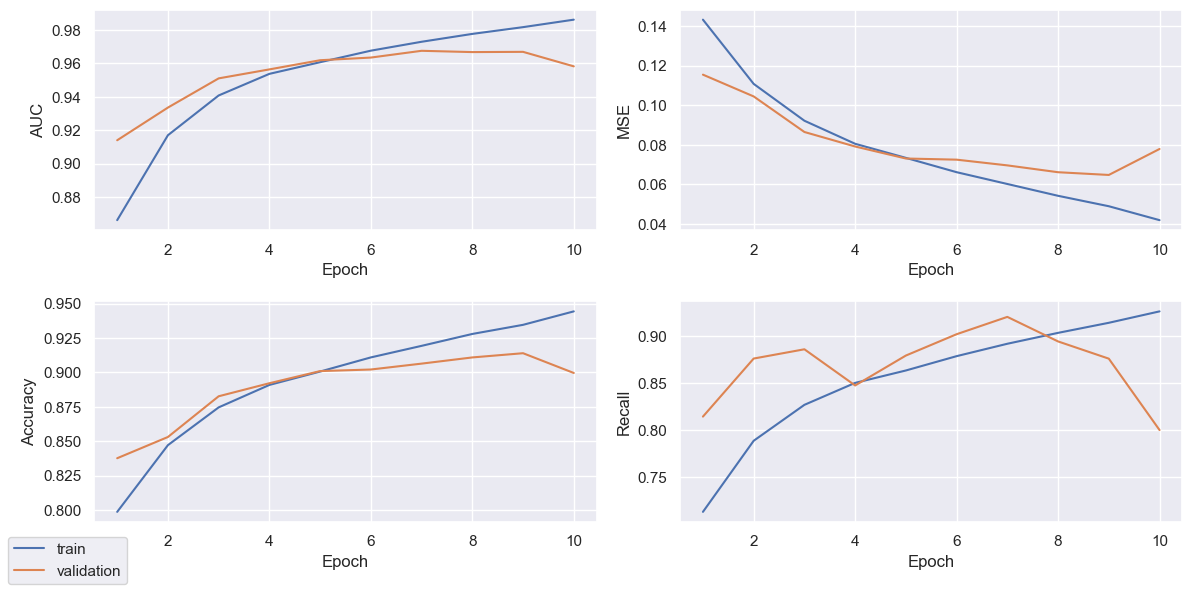

In [30]:
plot_model(chart_df)

#### Analysis of the Results

> * The results of this optimized model look **excellent**, with high accuracy and recall scores on both training and validation data. The loss values for both training and validation data are relatively low, indicating that the model is performing well in minimizing errors. The AUC scores for both training and validation data are high, which indicates that the model is able to distinguish between positive and negative cases effectively.
> * The fact that the model was able to achieve high accuracy and recall scores on the validation data indicates that the model is not overfitting like the previous models. In addition, the model does not seem to be underfitting either, as the accuracy and recall scores on both the training and validation data are high. 
> * In summary, this model seems to have struck a good balance between complexity and generalization ability. The high accuracy and recall scores indicate that it is able to accurately classify new data, and the low loss values indicate that it is able to minimize errors effectively. The near-perfect AUC scores suggest that the model is able to distinguish between positive and negative cases effectively. These results indicate that this model is a **strong candidate for deployment in real-world scenarios**.

## 5 - Summary of Results and Analysis

### Summary of Metrics

Below is a summary of the results achieved sorted by AUC in descending order. It is clear the optimized model 2 is the winner here, achieving the best overall results while minimizing overfitting. 

The ResNet model used as a baseline also produced decent results with minor signs of overfitting. One caveat of this model is that by looking at the plots, it showed significant metric fluctuations over the epochs. In other words, the model may produce inconsistent results on new unseen data.

Even the base model produced reasonable results for such a basic CNN architecture with minimal tuning. The validation data showed some underfitting, but that generally should be easier to fix than overfitting.

One interesting finding was the fact that the first optimized model with SGD optimizer produced very poor results with signs of severe overfitting and underfitting. This model clearly needed further improvement which in the end led me to build the optimized model 2.

One important observation is that these results were only possible because of the heavy preprocessing steps performed. I employed several techniques for resizing, data augmentation, normalization and random transformations to help increase the data variety and improve generalization performance. Without these steps, none of the results would have been possible.

The total training time using a mid-range GPU was 2 hours or about 30 minutes for each model, which was reasonable considering the number of images and complexity of the models.

In [41]:
summary_df.sort_values(by='val_auc', ascending=False)

,model,epoch,loss,auc,mse,accuracy,recall,val_loss,val_auc,val_mse,val_accuracy,val_recall
3,Optimized Model 2,10,0.145292,0.986089,0.041852,0.944296,0.925947,0.305759,0.958160,0.077814,0.899534,0.800179
0,ResNet50V2,10,0.345185,0.925167,0.105921,0.853426,0.802840,0.399942,0.910779,0.121796,0.831974,0.841941
1,Base Model,10,0.432682,0.875726,0.138173,0.804721,0.727804,0.461432,0.865015,0.149137,0.785024,0.789292
2,Optimized Model 1,10,0.390135,0.899177,0.122107,0.830434,0.754431,3.777455,0.441488,0.511305,0.426247,0.961532


### Summary of Hyperparameter Optimization Procedure

The hyperparameter steps were divided in two rounds as follows:

* The hyperparameter steps peformed in the first round of optimization consisted of convolutional layers with 16 filters of size 3x3, followed by a dropout layer with a dropout rate of 0.25, and a max pooling layer with a pool size of 2x2. This is then followed by additional convolutional layers with 32 filters of size 3x3 and an average pooling layer with a pool size of 2x2. The output is then flattened to a 1D array, and a dense layer with a single neuron and sigmoid activation is added. The input shape of the model is set to (batch_size, 96, 96, 3), and the optimizer used is Stochastic Gradient Descent (SGD) with a learning rate of 0.001 and momentum of 0.9. The model is compiled using binary cross-entropy loss and performance metrics including AUC, mean squared error (mse), accuracy, and recall are tracked during training.

The first round of optimization produced very poor results, which led me to research further and explore other options, leading me to an additional round of optimization as follows:

* The hyperparameter steps performed in the second optimization effort involved creating a sequential model with several convolutional layers and max pooling layers, followed by a fully connected layer with ReLU activation, dropout layer with a dropout rate of 0.5, and an output layer with a single neuron and sigmoid activation. The optimizer used is Adam with a learning rate of 0.001, and the model is compiled with binary cross-entropy loss and several metrics including AUC, MSE, accuracy, and recall. 

Given the time required to test new parameters and the fact that the second round of optimization achieved excellent results, I decided to accept the hyperparameters obtained in the last round of optimization and incorporate the changes in the final model, which was then used for the rest of the project.

### Model Visualization

For the model visualization I chose to use visualkeras, which is a Python package that allows for the visualization of Keras models. With visualkeras, one can quickly and easily generate a diagram of a Keras model's architecture, including the layers and their connections. This visualization can be especially helpful for understanding the model's structure, identifying potential issues such as overfitting or underfitting, and communicating the model's design to others. Visualkeras can also show the shape of the input and output tensors at each layer, which can help with debugging and ensuring the compatibility of different layers.

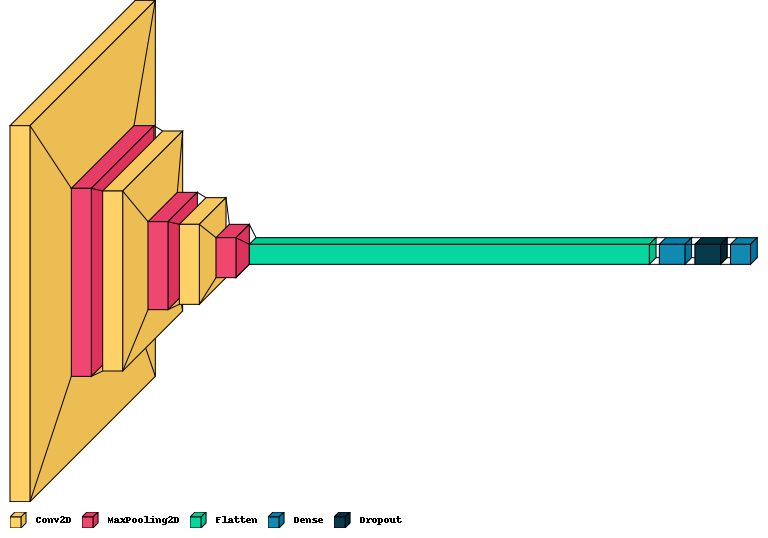

In [32]:
# plot_model(model[0], show_shapes=True, show_layer_names=True)

visualkeras.layered_view(model, legend=True)

### Confusion Matrix

A confusion matrix is a table that is used to evaluate the performance of a machine learning model by comparing the predicted labels to the true labels. It shows the number of true positives, true negatives, false positives, and false negatives for each category or label in a classification problem.

However, using absolute numbers in a confusion matrix can sometimes be difficult to interpret because it does not take into account the relative proportions of the different categories or labels. For example, a large number of false positives or false negatives in a category with very few instances may not be as important as a smaller number of false positives or false negatives in a category with many instances.

To address this issue, I used percentages instead of absolute numbers. By using percentages, the relative proportions of correct and incorrect classifications for each category can be more easily seen, making it easier to interpret the results.

In [33]:
# make predictions on the training data and convert probabilities into binary
y_probs_train = model.predict(train_generator)
y_pred_train = np.round(y_probs_train)

# get the true labels of the training data
y_true_train = train_generator.classes

# compute the confusion matrix on training data
cm_train = confusion_matrix(y_true_train, y_pred_train)

1376/1376 [==============================] - 115s 84ms/step


In [34]:
# make predictions on the validation data and convert probabilities into binary
y_probs_val = model.predict(val_generator)
y_pred_val = np.round(y_probs_val)

# get the true labels of the validation data
y_true_val = val_generator.classes

# compute the confusion matrix on validation data
cm_val = confusion_matrix(y_true_val, y_pred_val)

344/344 [==============================] - 29s 85ms/step


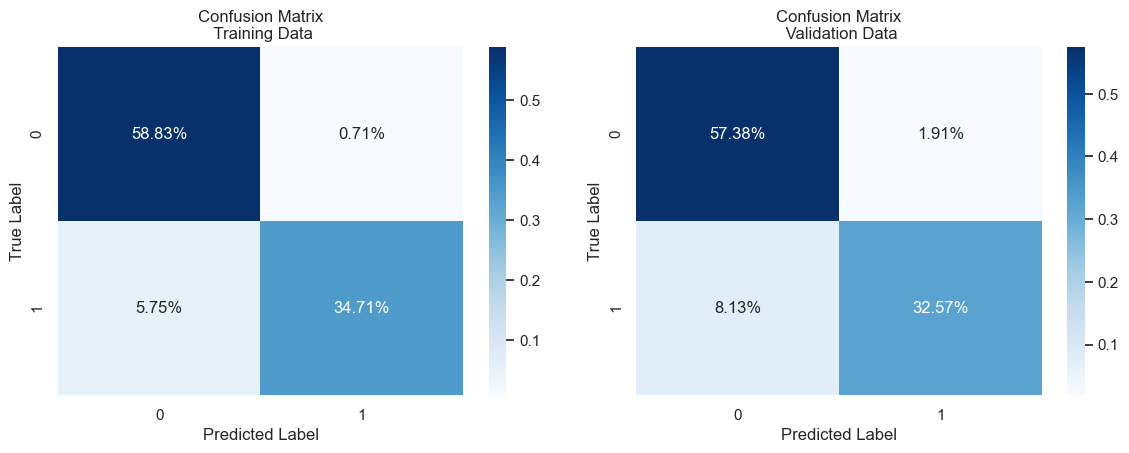

In [35]:
# Initialize figure
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Create plots
axs[0] = sns.heatmap(cm_train/np.sum(cm_train), fmt='.2%',
                     annot=True, cmap='Blues', ax=axs[0])
axs[0].set(title='Confusion Matrix\n Training Data')
axs[0].set(xlabel='Predicted Label', ylabel='True Label')

axs[1] = sns.heatmap(cm_val/np.sum(cm_val), fmt='.2%',
                     annot=True, cmap='Blues', ax=axs[1])
axs[1].set(title='Confusion Matrix\n Validation Data')
axs[1].set(xlabel='Predicted Label', ylabel='True Label')

# Plot charts
plt.tight_layout(pad=2.0)
plt.show()
plt.close()
None

#### Analysis of the Results

> * A CNN model that produced a confusion matrix with low misclassification percentage is a promising result, indicating that the model is accurately predicting the class labels of the input images. 
> * The low misclassification rate indicates that the model is well trained and has successfully learned the features that distinguish between different classes. A low misclassification rate can be attributed to several factors, including the quality of the training data, the choice of the model architecture, and the hyperparameters selected during training.

### ROC-AUC Curve

ROC-AUC is a widely used evaluation metric in binary classification problems. It measures the ability of the model to distinguish between positive and negative instances by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold values. For this project, I provide separate plots for training and validation data,

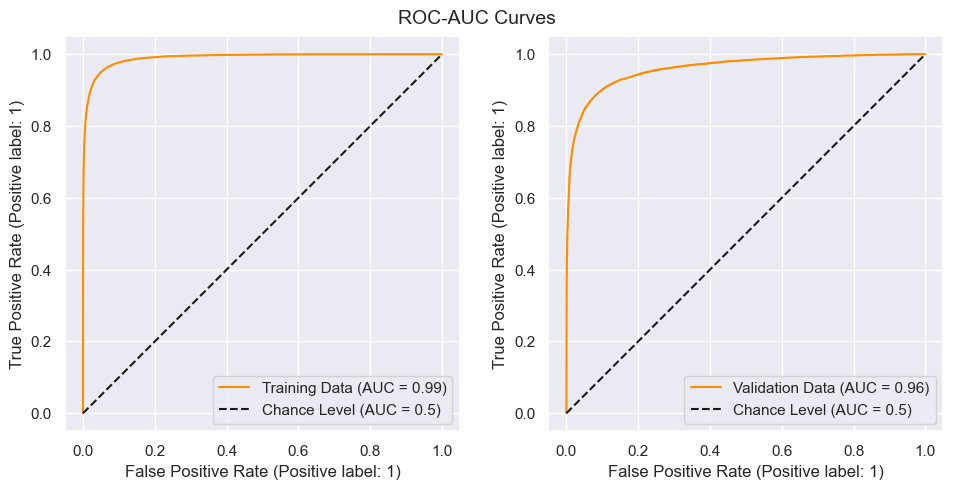

In [36]:
# Initialize figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create ROC-AUC plots
roc_display = RocCurveDisplay.from_predictions(
    y_true_train, y_probs_train, color = 'darkorange', 
    name='Training Data', ax=axs[0])
axs[0].plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)')
axs[0].axis('square')
axs[0].legend(loc='lower right')

roc_display = RocCurveDisplay.from_predictions(
    y_true_val, y_probs_val, color = 'darkorange', 
    name='Validation Data', ax=axs[1])
axs[1].plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)')
axs[1].axis('square')
axs[1].legend(loc='lower right')

# Plot charts
plt.suptitle('ROC-AUC Curves', fontsize=14)   
plt.tight_layout(pad=2.0)
plt.show()
plt.close()
None

#### Analysis of the Results

> * As we can see from the plots above the ROC-AUC charts show that the model's performance is very good, with high overall ROC-AUC scores for both training and validation data. This indicates that the model is very effective at distinguishing between positive and negative instances for both categories.
> * In addition, there's very little discrepancy between train and validation data, which leads me to conclude that the model is not experiencing overfitting.

## 6 - Conclusion

Based on all the metrics and visualizations I think I can reasonably say that I'm satisfied with results. The optimized model reached an AUC of over 0.9860 for the training data and 0.9581 for validation data, which was the primary metric used for the Kaggle competition. In addition, accuracy and recall metrics were high also for both test and validation data. 

As for the Kaggle submission, although the results were decent, with a private score of 0.8780 and public score of 0.8960, it's clear that the model has room for improvement. Given more computing resources and time, I'm confident that we could achieve even higher scores.

Recall is an important metric for medical-related classification models because it measures the proportion of true positives that were correctly identified by the model. In other words, recall indicates the model's ability to correctly identify cases that have a certain condition or disease, which is particularly important in medical settings.

For example, let's say we have a classification model that predicts whether a patient has a certain disease or not. A high recall score means that the model is correctly identifying a high percentage of patients who actually have the disease. This is important because it can help healthcare professionals to identify and treat patients who are at risk, potentially leading to better outcomes and improved patient care.

On the other hand, a low recall score indicates that the model is missing a significant number of patients who have the disease. This could be a serious issue if patients are not being diagnosed and treated appropriately, potentially leading to negative health outcomes.

### Lessons Learned and Key Takeways

In closing, this project was both fun and informative, providing many valuable lessons for future work in the field of CNNs. Some of the key takeaways from this project for me include:

> * There are many different architectures for CNNs, each with its strengths and weaknesses. It's essential to choose an appropriate architecture that is suitable for the task at hand and optimize the hyperparameters of the model to achieve the best performance.
> * The importance of carefully selecting hyperparameters such as learning rate, batch size, and activation functions. However, despite extensive efforts in searching for the optimal hyperparameters, the performance of the model may not improve significantly or may even worsen. This could be due to various reasons such as a small dataset, imbalanced classes, or high dimensionality of the input data. 
> * In my case, the first optimization effort significantly worsened the base model, which required me to spend significant time on researching and investigating the underlying reasons for it. 
> * The value of using pre-trained models or transfer learning to improve model performance and use as a baseline
> * The need for extensive data preprocessing and augmentation to improve model robustness and generalization. In my particular case, data preparation was as important as model selection and hyperparameter tuning.
> * The usefulness of visualizing model performance through confusion matrices, ROC curves, and other tools.
> * The potential for overfitting or underfitting, and strategies to mitigate these issues. CNN models can easily overfit to the training data, causing poor generalization to new data, especially complex architectures.
> * The benefits of experimenting with different architectures, including the number of layers and filters, to optimize model performance.
> * With more time and more computing resources, it would be interesting to try to optimize the model further and perhaps run more epochs to see if an even better result could be achieved.

#### Prediction on Test Data and Result Submission

The purpose of this code is to generate a submission file that can be used to obtain the final score for my model on the original Kaggle competition. The file will contain the predictions made by the optimized model on the test dataset, which is not available to during training. 

In [42]:
%%time

# Create a dataframe for the data generator
test_df = pd.DataFrame({'id':os.listdir(test_path)})

# Define generators for test data
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='id',
    y_col=None,
    target_size=(96, 96),
    batch_size=batch_size,
    shuffle=False,
    class_mode=None)

# Reset the index of the test data generator back to 0
test_generator.reset()

# Make predictions on test data
y_pred_test = model.predict(test_generator)

# Prepare submission file
submission = pd.DataFrame()
submission['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission['label'] = y_pred_test
submission.to_csv(base_path + '\submission.csv', index=False)
submission.head()

Found 57458 validated image filenames.
449/449 [==============================] - 193s 431ms/step
Wall time: 3min 18s


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,6.025478e-09
1,0000ec92553fda4ce39889f9226ace43cae3364e,1.000000e+00
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,8.909746e-29
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,1.000000e+00
4,000270442cc15af719583a8172c87cd2bd9c7746,0.000000e+00
